In [3]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "pronosticos-miad"

##### 1.  Importación de librerías requeridas

In [4]:
### Para el modelado
library(earth)
library(mgcv)
library(caret)     # para optimizar proceso de tunning

#Otros de manipulación de datos
library(tseries)  #manipulación series de tiempo
library(tsfeatures) # Obtención de features relevantes
library(tidyverse) #Data manipulation
library(fields)  #Data manipulation
library(forecast)  # para función pronosticos
library(quantmod) #Para obtener datos financiera
library(dygraphs)  # data visualization
library(dplyr)    # data wrangling
library(ggplot2)  # gráficos 
theme_set(theme_bw())
options(warn = 0) 

Loading required package: Formula

Loading required package: plotmo

Loading required package: plotrix

Loading required package: TeachingDemos

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: spam

Spam version 2.9-1 (2022-08-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘packa

##### 2.  Descarga de datos financieros

In [9]:
start<-format(as.Date("2016-05-01"),"%Y-%m-%d")
end<-format(as.Date("2018-01-28"),"%Y-%m-%d")

precios <-function(simbolo)
{
  ##Obtener precios stocks de Yahoo FInance
  datos <- getSymbols(simbolo, auto.assign = FALSE, from=start, to=end)
  ## Elimar faltantes:
  datos<-na.omit(datos)
  ##mantener columnas con precios cierre 4:
  datos <- datos[,4]
  ##Para hacerlo datos accesibles en el global environment:
  assign(simbolo, datos, envir = .GlobalEnv)
}

##Llamar el activo de interés, pueden ser varios:
precios("AMZN")

##### 3. Visualización de serie de interés

In [10]:
##Juntar los datos y renombrarlos:
Pr<-merge.xts(META) %>% na.omit()
head(Pr)
colnames(Pr) <- c("Meta")
head(Pr)
##Serie tiempo, grafica interactiva
Precios<- dygraph(Pr[,c(1)], main="Precios ") %>%
  dyAxis("y", label = "Precios") %>%
  dyRangeSelector(dateWindow = c("2016-05-01", "2018-01-28"))%>%
  dyOptions(colors = RColorBrewer::brewer.pal(4,"Set1"))
Precios

           META.Close
2016-05-02     118.57
2016-05-03     117.43
2016-05-04     118.06
2016-05-05     117.81
2016-05-06     119.49
2016-05-09     119.24

             Meta
2016-05-02 118.57
2016-05-03 117.43
2016-05-04 118.06
2016-05-05 117.81
2016-05-06 119.49
2016-05-09 119.24

HTML widgets cannot be represented in plain text (need html)

##### 4. Generación de formato Indexado a fechas

In [8]:
##Index format.
xpr <- as.xts(Pr, dateFormat = "Date")
Pr_index <- fortify.zoo(xpr)
head(Pr_index)
nrow(Pr)

,Index,Meta
,<date>,<dbl>
1,2016-05-02,118.57
2,2016-05-03,117.43
3,2016-05-04,118.06
4,2016-05-05,117.81
5,2016-05-06,119.49
6,2016-05-09,119.24


[1] 439

##### 5. Partición de datos de entrenamiento y prueba

In [11]:
#Partimos serie para train & test
h <- round(length(Pr)*0.05, digits = 0 )
h
Pr_tra <- Pr[1:(nrow(Pr) - h), ]
Pr_tes<- Pr[(nrow(Pr) - h + 1):nrow(Pr), ]

[1] 22

In [12]:
#Pasamos a formato data frame para poder generar los retrasos
Pr_df_tra<-as.data.frame(Pr_tra)
head(Pr_df_tra)
str(Pr_df_tra)

,Meta
,<dbl>
2016-05-02,118.57
2016-05-03,117.43
2016-05-04,118.06
2016-05-05,117.81
2016-05-06,119.49
2016-05-09,119.24


'data.frame':	417 obs. of  1 variable:
 $ Meta: num  119 117 118 118 119 ...


##### 6. Generación de features o rezagos y obtención base datos

frequency,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,entropy,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,0.9901344,1.737658e-09,19.22551,4.38829,0.7349023,1.041272,0.09337242,0.9927452,9.236512,-0.01550976,0.03439838,-0.4949165,0.2821557


x_pacf5 diff1x_pacf5 diff2x_pacf5 
  0.98585140   0.01221966   0.48969532

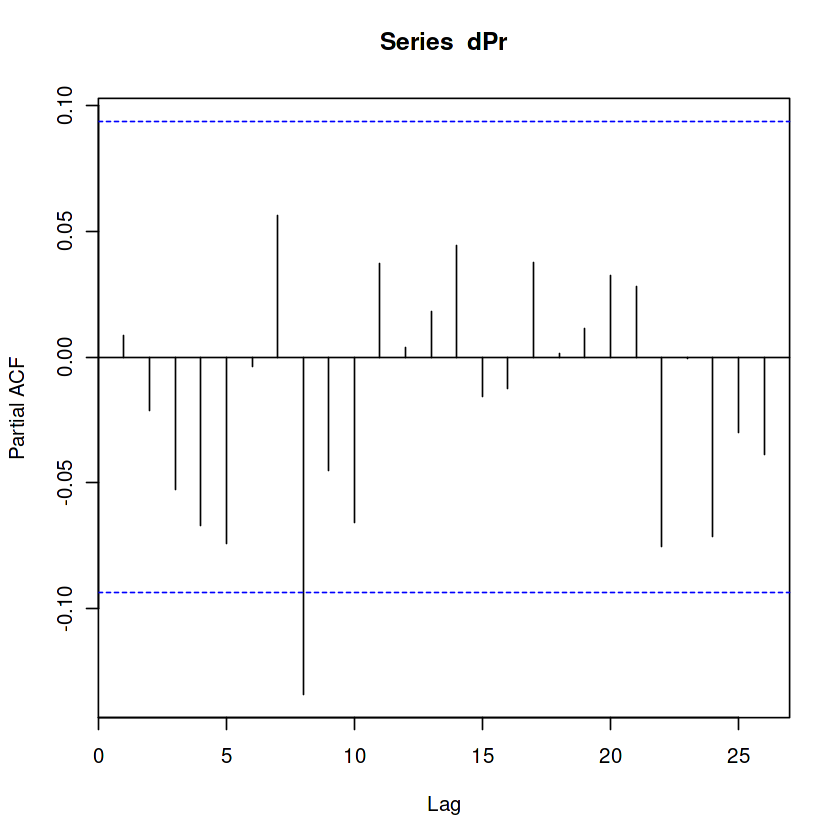

In [15]:
#Obteneomos features:
tsfeatures(Pr_df_tra$Meta)
pacf_features(Pr_df_tra$Meta)
#Visualiamos los rezagos autorregresivos, haciendo estacionaria la serie:
dPr<-diff(Pr)%>% na.omit()
pacf(dPr)

In [16]:
#Generamos retrasos
lag_pr = lag(Pr_df_tra,n=1L) 
lag2_pr = lag(Pr_df_tra,n=2L) 
lag3_pr = lag(Pr_df_tra,n=3L)
lag4_pr = lag(Pr_df_tra,n=4L)

In [17]:
#Unimos los nuevos features o retrasos en una base
Pr_all_train<-cbind(Pr_df_tra, lag_pr, lag2_pr, lag3_pr, lag4_pr) %>%na.omit()
colnames(Pr_all_train)<-c("Meta","l1","l2","l3","l4")
head(Pr_all_train)

,Meta,l1,l2,l3,l4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-05-06,119.49,117.81,118.06,117.43,118.57
2016-05-09,119.24,119.49,117.81,118.06,117.43
2016-05-10,120.50,119.24,119.49,117.81,118.06
2016-05-11,119.52,120.50,119.24,119.49,117.81
2016-05-12,120.28,119.52,120.50,119.24,119.49
2016-05-13,119.81,120.28,119.52,120.50,119.24


In [18]:
Pr_all_train$trend = 1:nrow(Pr_all_train)
str(Pr_all_train)
head(Pr_all_train)
tail(Pr_all_train)

'data.frame':	413 obs. of  6 variables:
 $ Meta : num  119 119 120 120 120 ...
 $ l1   : num  118 119 119 120 120 ...
 $ l2   : num  118 118 119 119 120 ...
 $ l3   : num  117 118 118 119 119 ...
 $ l4   : num  119 117 118 118 119 ...
 $ trend: int  1 2 3 4 5 6 7 8 9 10 ...
 - attr(*, "na.action")= 'omit' Named int [1:4] 1 2 3 4
  ..- attr(*, "names")= chr [1:4] "2016-05-02" "2016-05-03" "2016-05-04" "2016-05-05"


,Meta,l1,l2,l3,l4,trend
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2016-05-06,119.49,117.81,118.06,117.43,118.57,1
2016-05-09,119.24,119.49,117.81,118.06,117.43,2
2016-05-10,120.50,119.24,119.49,117.81,118.06,3
2016-05-11,119.52,120.50,119.24,119.49,117.81,4
2016-05-12,120.28,119.52,120.50,119.24,119.49,5
2016-05-13,119.81,120.28,119.52,120.50,119.24,6


,Meta,l1,l2,l3,l4,trend
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2017-12-15,180.18,178.39,178.30,176.96,179.04,408
2017-12-18,180.82,180.18,178.39,178.30,176.96,409
2017-12-19,179.51,180.82,180.18,178.39,178.30,410
2017-12-20,177.89,179.51,180.82,180.18,178.39,411
2017-12-21,177.45,177.89,179.51,180.82,180.18,412
2017-12-22,177.20,177.45,177.89,179.51,180.82,413


In [19]:
#Separamos objetos para las secciones de entrenamiento con todos los features X_train:
x_train <- Pr_all_train %>% 
  select(starts_with(c("l", "t")))
head(x_train)

,l1,l2,l3,l4,trend
,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2016-05-06,117.81,118.06,117.43,118.57,1
2016-05-09,119.49,117.81,118.06,117.43,2
2016-05-10,119.24,119.49,117.81,118.06,3
2016-05-11,120.50,119.24,119.49,117.81,4
2016-05-12,119.52,120.50,119.24,119.49,5
2016-05-13,120.28,119.52,120.50,119.24,6


In [21]:
#Igual para la respuesta y_train:
y_train <- Pr_all_train %>% 
  select(Meta)
head(y_train)

,Meta
,<dbl>
2016-05-06,119.49
2016-05-09,119.24
2016-05-10,120.50
2016-05-11,119.52
2016-05-12,120.28
2016-05-13,119.81


##### 7. Modelo de Regresión MARS

In [23]:
mars_mod <- earth(
  Meta ~ ., data=Pr_all_train, pmethod="backward" )

In [24]:
#Podemos ver el resultado del modelo:
print(mars_mod)

Selected 2 of 3 terms, and 1 of 5 predictors
Termination condition: RSq changed by less than 0.001 at 3 terms
Importance: l1, l2-unused, l3-unused, l4-unused, trend-unused
Number of terms at each degree of interaction: 1 1 (additive model)
GCV 2.578776    RSS 1049.618    GRSq 0.9945848    RSq 0.9946372


En este modelo, podemos ver que se seleccionaron 2 de 3 términos, esos son, la ordenada al origen, mas dos splines que de manera general, ajusta a toda la serie; es decir, todas las funciones splines son de orden lineal. También, que de los 5 features o rezagos, sólo se uso el primero. Podemos tambien ver los métricos de error como el Generalized Cross Validation, el RSS y demás.

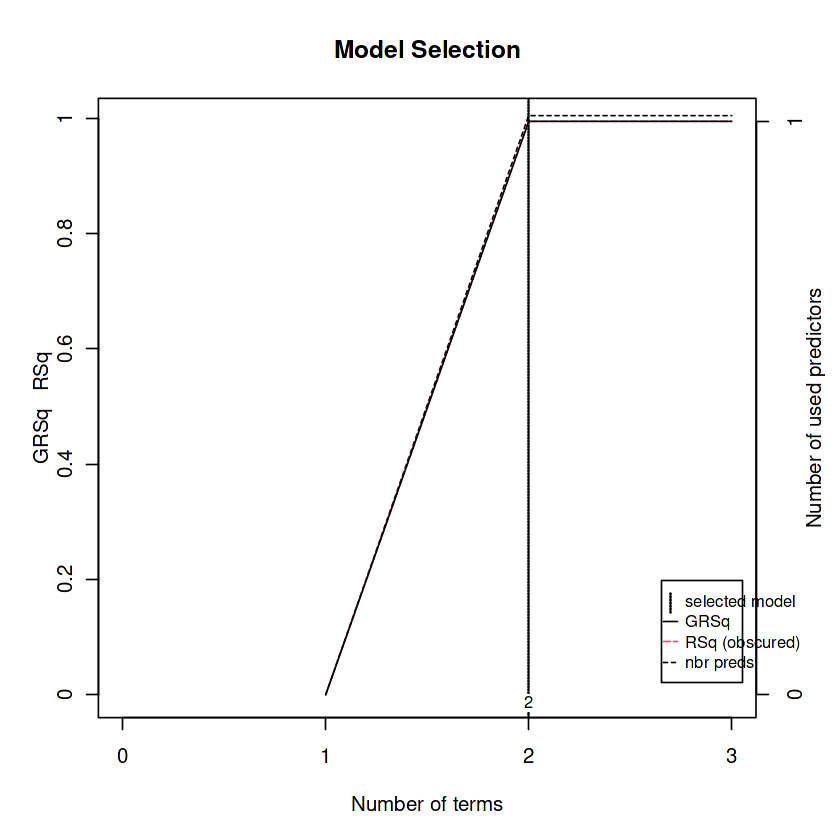

In [25]:
plot(mars_mod, which = 1)

De manera complementaria al resultado anterior, en esta gráfica lo que nos muestra es que tenemos el número de términos y cómo se llega al número óptimo de éstos en 3, que es donde una línea vertical en 2, cruza con la línea de selected modelo. Del lado derecho, nos indica que el número de predictores o rezagos empleados es de 1.

##### 8. Resultados y Visualización

In [27]:
# Unimos las base junto con los resultados de ajuste
Pr_train <- Pr_all_train %>% 
  mutate(
    fitted_mars = fitted(mars_mod)[,1]
  )

head(Pr_train)

,Meta,l1,l2,l3,l4,trend,fitted_mars
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
2016-05-06,119.49,117.81,118.06,117.43,118.57,1,117.9454
2016-05-09,119.24,119.49,117.81,118.06,117.43,2,119.6284
2016-05-10,120.50,119.24,119.49,117.81,118.06,3,119.3780
2016-05-11,119.52,120.50,119.24,119.49,117.81,4,120.6402
2016-05-12,120.28,119.52,120.50,119.24,119.49,5,119.6585
2016-05-13,119.81,120.28,119.52,120.50,119.24,6,120.4198


In [28]:
#Damos formato de xts para poder manipular los datos y graficarlos con ggplot más adelante
x <- as.xts(Pr_train, dateFormat = "Date")
Pr_train2 <- fortify.zoo(x)
head(Pr_train2)

,Index,Meta,l1,l2,l3,l4,trend,fitted_mars
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-05-06,119.49,117.81,118.06,117.43,118.57,1,117.9454
2,2016-05-09,119.24,119.49,117.81,118.06,117.43,2,119.6284
3,2016-05-10,120.50,119.24,119.49,117.81,118.06,3,119.3780
4,2016-05-11,119.52,120.50,119.24,119.49,117.81,4,120.6402
5,2016-05-12,120.28,119.52,120.50,119.24,119.49,5,119.6585
6,2016-05-13,119.81,120.28,119.52,120.50,119.24,6,120.4198


In [29]:
# Podemos dar formato para que el etiquetado en la visualización sea más sencilla.
Pr_train3 <- Pr_train2 %>% 
  select(Index, Meta, starts_with("fitted")) %>% 
  gather("model", "value", -Index, -Meta) %>% 
  mutate(model = str_remove(model, "fitted_"))
tail(Pr_train3)

,Index,Meta,model,value
,<date>,<dbl>,<chr>,<dbl>
408,2017-12-15,180.18,mars,178.6333
409,2017-12-18,180.82,mars,180.3062
410,2017-12-19,179.51,mars,180.3062
411,2017-12-20,177.89,mars,179.7553
412,2017-12-21,177.45,mars,178.1324
413,2017-12-22,177.20,mars,177.6916


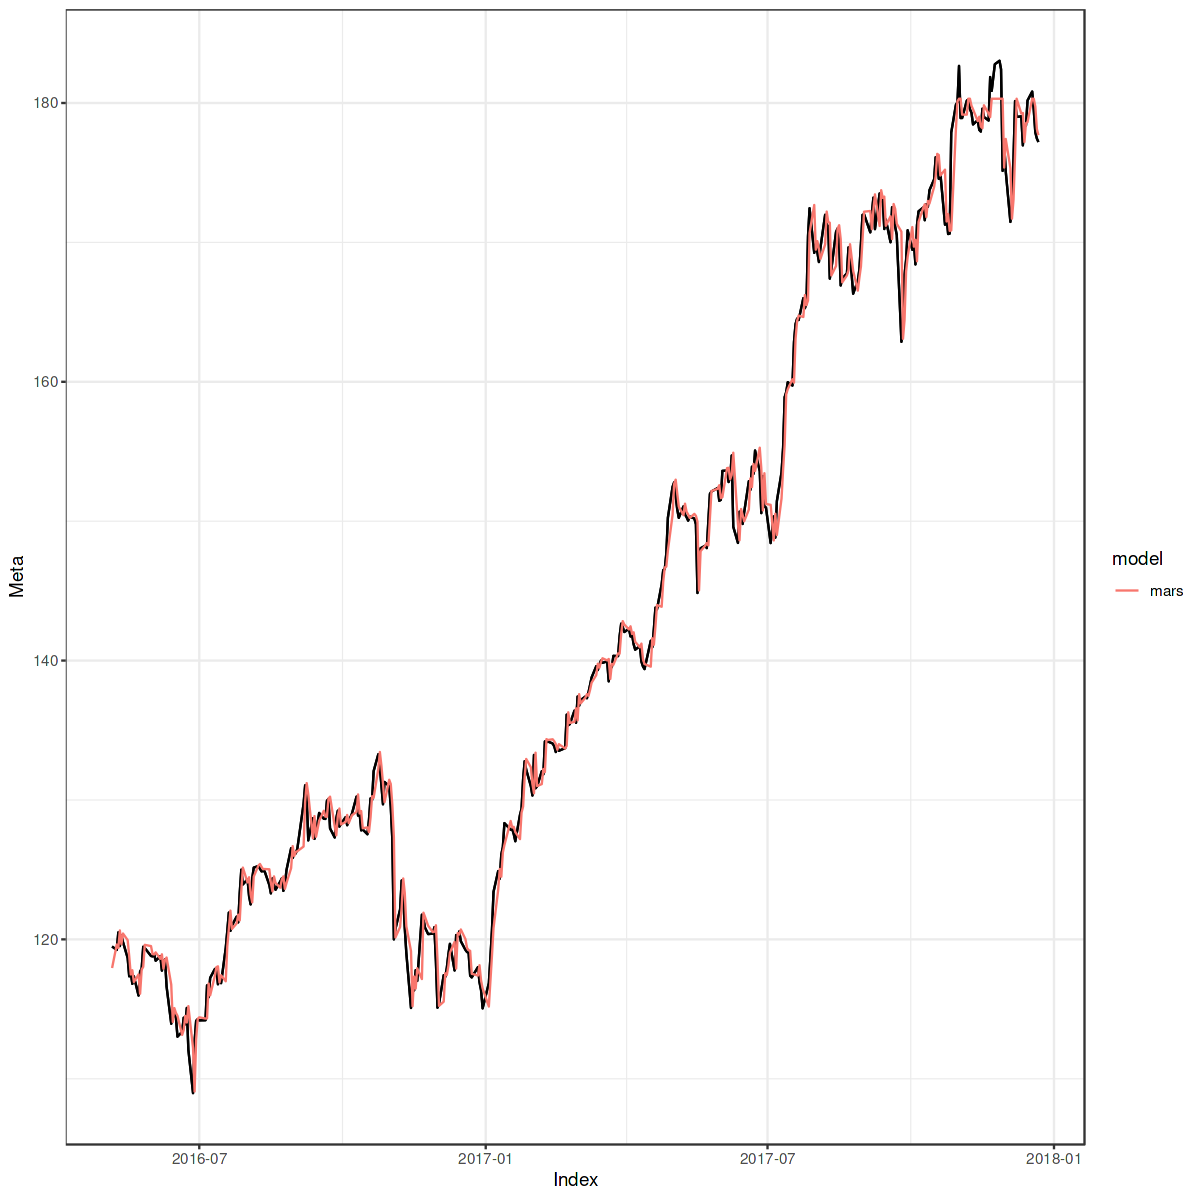

In [30]:
## Graficamos:
library(ggplot2)
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(Pr_train3,aes(Index,Meta))+geom_line() +
geom_line()+
geom_line(aes(y=value, color=model))
#theme(plot.title = element_text(size=30), legend.position="upper", cex=100)

##### 9. Predicciones: Fase de Prueba

In [31]:
#Procedemos con pasar los datos de un formato xts, a un formato data.frame para facilitar la generación de rezagos.
Pr_test2<-as.data.frame(Pr_tes)
#head(Pr_test2)

In [32]:
#Generación de rezagos o features: debemos generar los mismos tipos de features que en la parte de entrenamiento.
lag1_pr_test = lag(Pr_test2,n=1L) 
lag2_pr_test = lag(Pr_test2,n=2L) 
lag3_pr_test = lag(Pr_test2,n=3L) 
lag4_pr_test = lag(Pr_test2,n=4L) 

Pr_all_test<-cbind(Pr_test2, lag1_pr_test, lag2_pr_test, lag3_pr_test, lag4_pr_test) %>%na.omit()
colnames(Pr_all_test)<-c("Meta","l1","l2","l3","l4")
#Generamos la tendencia:
Pr_all_test$trend = 1:nrow(Pr_all_test)
#Renombramos:
colnames(Pr_all_test)<-c("Meta","l1","l2","l3","l4", "trend")
dim(Pr_all_test)
head(Pr_all_test)
str(Pr_all_test)

[1] 18  6

,Meta,l1,l2,l3,l4,trend
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2018-01-02,181.42,176.46,177.92,177.62,175.99,1
2018-01-03,184.67,181.42,176.46,177.92,177.62,2
2018-01-04,184.33,184.67,181.42,176.46,177.92,3
2018-01-05,186.85,184.33,184.67,181.42,176.46,4
2018-01-08,188.28,186.85,184.33,184.67,181.42,5
2018-01-09,187.87,188.28,186.85,184.33,184.67,6


'data.frame':	18 obs. of  6 variables:
 $ Meta : num  181 185 184 187 188 ...
 $ l1   : num  176 181 185 184 187 ...
 $ l2   : num  178 176 181 185 184 ...
 $ l3   : num  178 178 176 181 185 ...
 $ l4   : num  176 178 178 176 181 ...
 $ trend: int  1 2 3 4 5 6 7 8 9 10 ...
 - attr(*, "na.action")= 'omit' Named int [1:4] 1 2 3 4
  ..- attr(*, "names")= chr [1:4] "2017-12-26" "2017-12-27" "2017-12-28" "2017-12-29"


In [34]:
# Tambien, damos formato indexado a la fecha.
yt <- as.xts(Pr_all_test, dateFormat = "Date")
Pr_test2 <- fortify.zoo(yt)
head(Pr_test2)

,Index,Meta,l1,l2,l3,l4,trend
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2018-01-02,181.42,176.46,177.92,177.62,175.99,1
2,2018-01-03,184.67,181.42,176.46,177.92,177.62,2
3,2018-01-04,184.33,184.67,181.42,176.46,177.92,3
4,2018-01-05,186.85,184.33,184.67,181.42,176.46,4
5,2018-01-08,188.28,186.85,184.33,184.67,181.42,5
6,2018-01-09,187.87,188.28,186.85,184.33,184.67,6


In [35]:
#Neuvamente, podemos crear un objeto que contemple sólamente los rezagos o features de la parte de prueba, este sería el x_test.
x_test <- Pr_test2 %>% 
  select(starts_with(c("l", "t")))
head(x_test)

,l1,l2,l3,l4,trend
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,176.46,177.92,177.62,175.99,1
2,181.42,176.46,177.92,177.62,2
3,184.67,181.42,176.46,177.92,3
4,184.33,184.67,181.42,176.46,4
5,186.85,184.33,184.67,181.42,5
6,188.28,186.85,184.33,184.67,6


In [36]:
##Llamamos de manera similar, a la respuesta de la parte de prueba.
y_test <- Pr_test2%>% 
  select(Meta)
dim(y_test)

[1] 18  1

In [38]:
#Predicciones Modelo MARS
pred_mars = predict(mars_mod, x_test)[,1]
str(pred_mars)

 num [1:18] 177 180 180 180 180 ...


In [39]:
#Podemos unir los resultados a manera que se generen columnas con los resultados de ajuste de los modelos:
Pr_test3 <- Pr_test2 %>% 
  mutate(
    pred_mars = predict(mars_mod, x_test)[,1]
  ) 
head(Pr_test3)
str(Pr_test3)

,Index,Meta,l1,l2,l3,l4,trend,pred_mars
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2018-01-02,181.42,176.46,177.92,177.62,175.99,1,176.6998
2,2018-01-03,184.67,181.42,176.46,177.92,177.62,2,180.3062
3,2018-01-04,184.33,184.67,181.42,176.46,177.92,3,180.3062
4,2018-01-05,186.85,184.33,184.67,181.42,176.46,4,180.3062
5,2018-01-08,188.28,186.85,184.33,184.67,181.42,5,180.3062
6,2018-01-09,187.87,188.28,186.85,184.33,184.67,6,180.3062


'data.frame':	18 obs. of  8 variables:
 $ Index    : Date, format: "2018-01-02" "2018-01-03" ...
 $ Meta     : num  181 185 184 187 188 ...
 $ l1       : num  176 181 185 184 187 ...
 $ l2       : num  178 176 181 185 184 ...
 $ l3       : num  178 178 176 181 185 ...
 $ l4       : num  176 178 178 176 181 ...
 $ trend    : num  1 2 3 4 5 6 7 8 9 10 ...
 $ pred_mars: num  177 180 180 180 180 ...


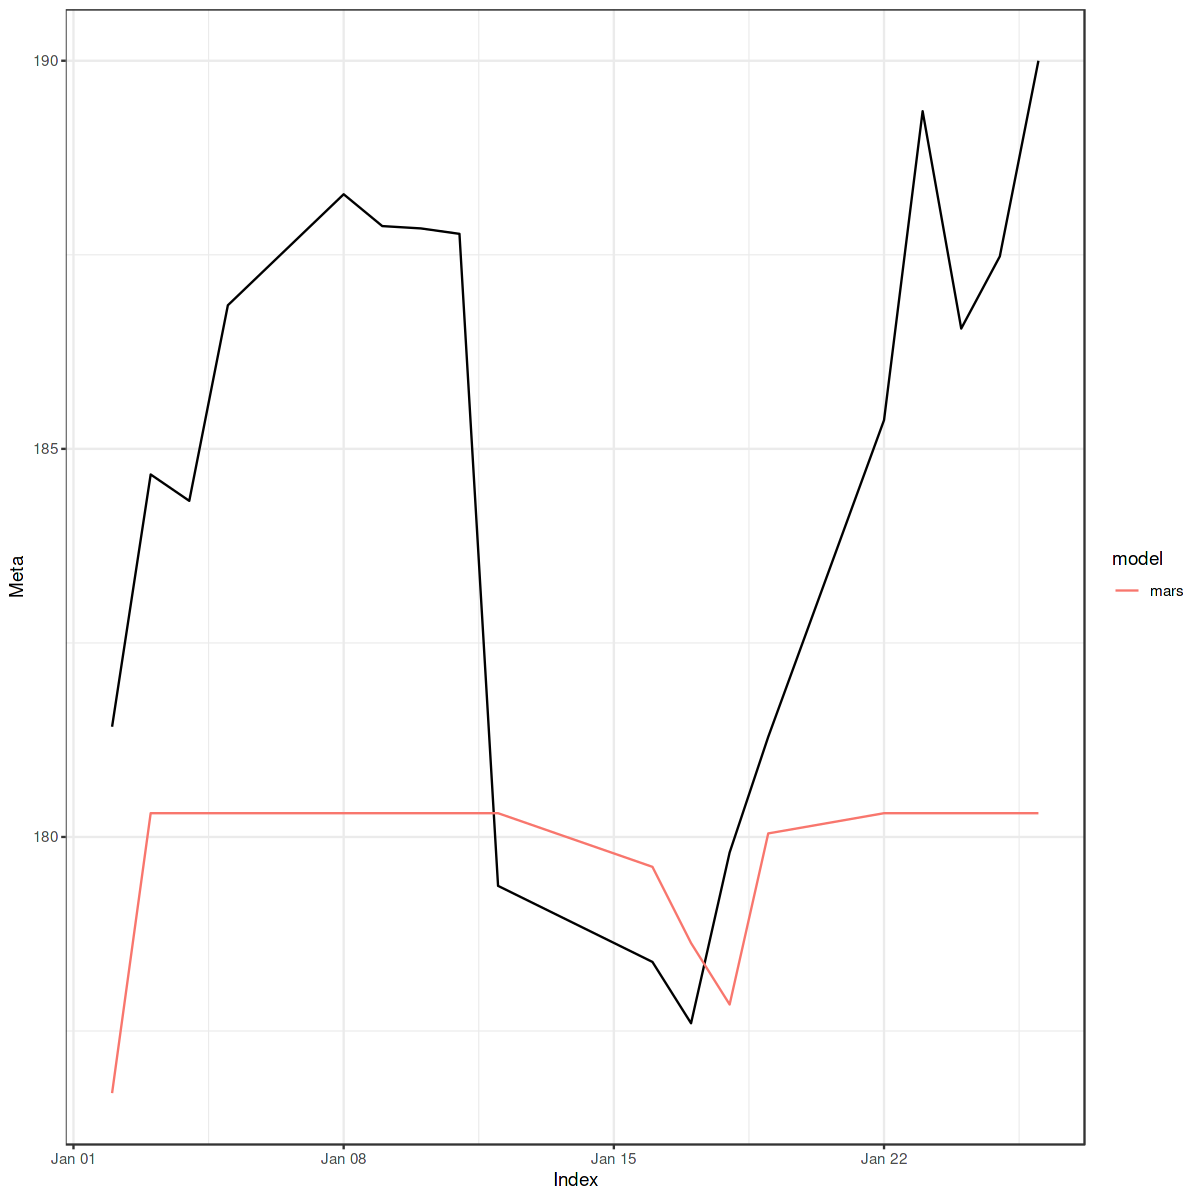

In [41]:
##Podemos graficar sólo el segmento de pronóstico:
Pr_test3 %>% 
  select(Index, Meta, starts_with("pred")) %>% 
  gather("model", "forecast", -Index, -Meta) %>% 
  mutate(model = str_remove(model, "pred_")) %>% 
  ggplot(aes(Index, Meta)) +
  geom_line() +
  geom_line(aes(y = forecast, color = model))

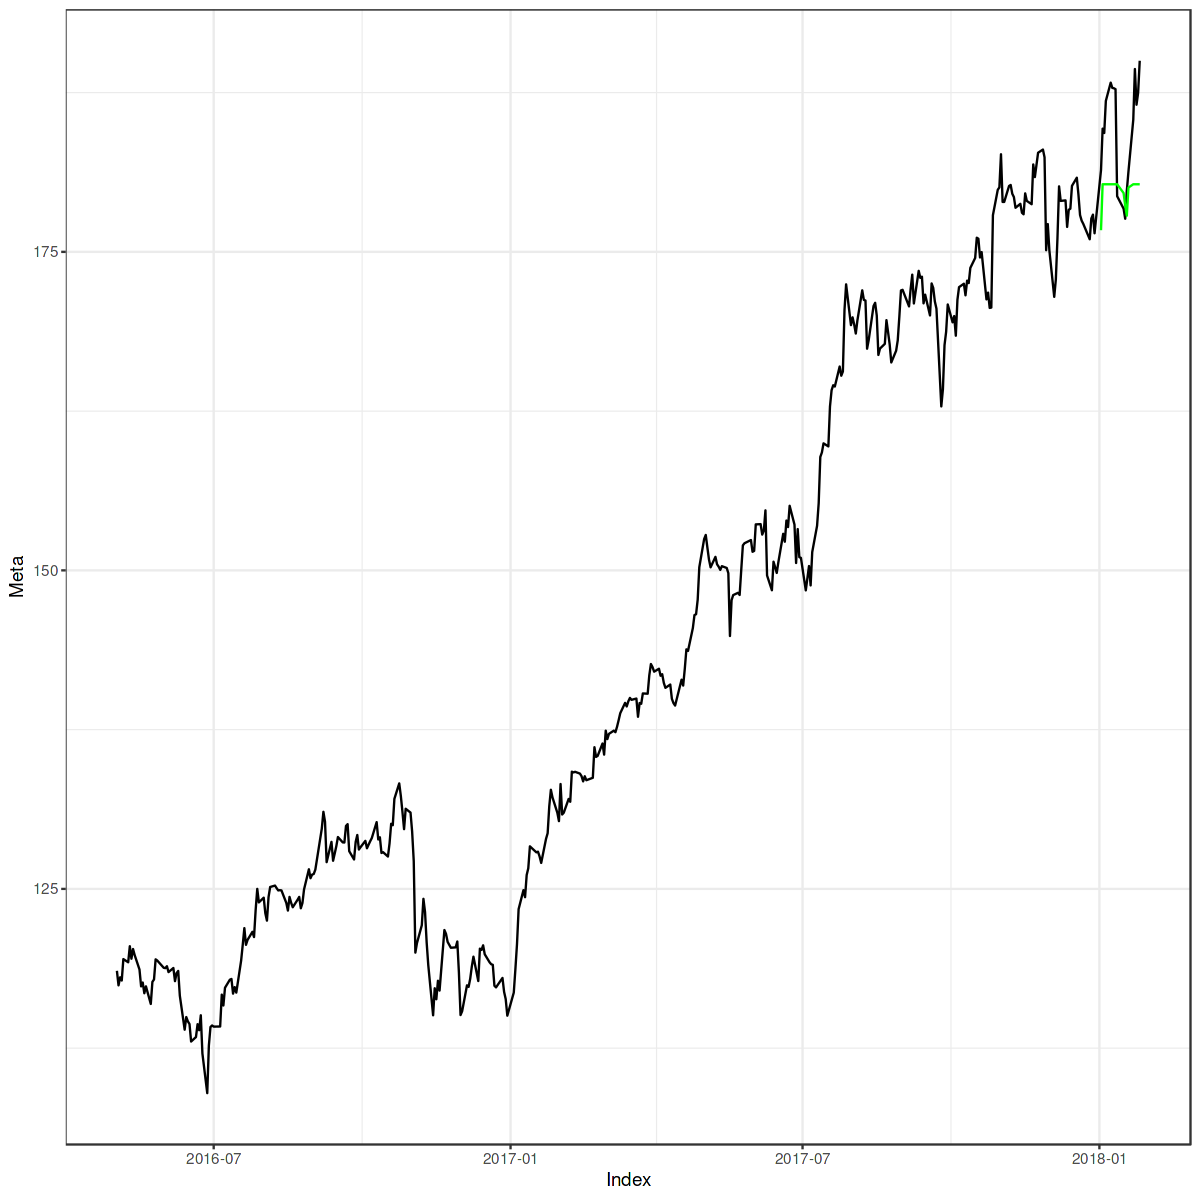

In [43]:
Pr_index %>%
  ggplot(aes(Index, Meta)) +
  geom_line() +
  geom_line(aes(Index, pred_mars), data = Pr_test3, color = "green")

##### 10. Conlusión sobre el Modelo

In [44]:
# Métricas de desempeño
yardstick::metrics(Pr_test3, truth = Meta, estimate = pred_mars)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,5.9360778
rsq,standard,0.3351839
mae,standard,5.2112346
